In [27]:
using LinearAlgebra, Plots, Printf, SparseArrays, IterativeSolvers

In [28]:
h = .1; m = convert(Int64,1/h)-1;
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x));

In [29]:
f = (x,y) -> (x,y)
U = map(f,X,Y);

In [30]:
U

9×9 Matrix{Tuple{Float64, Float64}}:
 (0.1, 0.9)  (0.2, 0.9)  (0.3, 0.9)  …  (0.7, 0.9)  (0.8, 0.9)  (0.9, 0.9)
 (0.1, 0.8)  (0.2, 0.8)  (0.3, 0.8)     (0.7, 0.8)  (0.8, 0.8)  (0.9, 0.8)
 (0.1, 0.7)  (0.2, 0.7)  (0.3, 0.7)     (0.7, 0.7)  (0.8, 0.7)  (0.9, 0.7)
 (0.1, 0.6)  (0.2, 0.6)  (0.3, 0.6)     (0.7, 0.6)  (0.8, 0.6)  (0.9, 0.6)
 (0.1, 0.5)  (0.2, 0.5)  (0.3, 0.5)     (0.7, 0.5)  (0.8, 0.5)  (0.9, 0.5)
 (0.1, 0.4)  (0.2, 0.4)  (0.3, 0.4)  …  (0.7, 0.4)  (0.8, 0.4)  (0.9, 0.4)
 (0.1, 0.3)  (0.2, 0.3)  (0.3, 0.3)     (0.7, 0.3)  (0.8, 0.3)  (0.9, 0.3)
 (0.1, 0.2)  (0.2, 0.2)  (0.3, 0.2)     (0.7, 0.2)  (0.8, 0.2)  (0.9, 0.2)
 (0.1, 0.1)  (0.2, 0.1)  (0.3, 0.1)     (0.7, 0.1)  (0.8, 0.1)  (0.9, 0.1)

In [31]:
f = (x,y) -> x*y
U = map(f,X,Y);

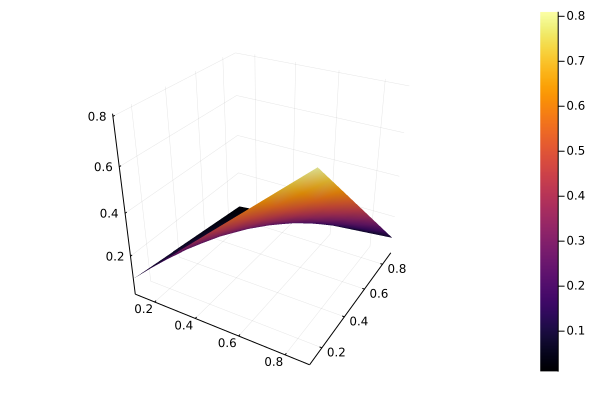

In [32]:
p1 = surface(x, y, U)

The conjugate gradient algorithm

In [33]:
function CG(A,b,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while norm(r) > eps
        q = A*p
        a = (r'*r)/(p'*q)
        x = x + a*p
        r_old = r
        r = r - a*q
        b = (r'*r)/(r_old'*r_old)
        p = r + b*p 
        n += 1
    end
    @printf("CG took %i iterations",n)
    x
end

CG (generic function with 1 method)

In [34]:
A = SymTridiagonal(fill(4.0,10),fill(-1.0,9));
b = randn(10);

In [35]:
x = CG(A,b,1e-16);
x - A\b |> norm

CG took 10 iterations

2.1594520391724489e-16

The conjugate gradient algorithm for general linear functions and inner products

In [36]:
function CG(f,b,⋄,eps::Float64)
   x = 0.0*b; r = b; p = r; n = 0;
   while r⋅r > eps^2
        q = f(p)
        a = (r⋅r)/(p⋅q)
        x = x + a*p
        r_old = r
        r = r - a*q
        b = (r⋅r)/(r_old⋅r_old)
        p = r + b*p
        n += 1
    end
    @printf("CG took %i iterations",n)
    x
end

CG (generic function with 2 methods)

In [37]:
f = x -> A*x
function ⋄(x,y)
    x'*y
end

⋄ (generic function with 1 method)

In [38]:
x = CG(f,b,⋄,1e-16)
A\b - x |> norm

CG took 10 iterations

2.1594520391724489e-16

Sylvester matrix equations

$$ A X + X B = C.$$

In [39]:
n = 400;
C = randn(n,n);
A = SymTridiagonal(fill(2.0,n),fill(-1.0,n-1));

In [40]:
X = CG(f,C,⋄,1e-16)

CG took 799 iterations

400×400 Matrix{Float64}:
  -1.79267    9.21897    2.45073  …   -12.375       12.1617   -4.07624
  -2.28429   19.1708     4.87601      -24.8373      23.5622   -8.43593
  -3.04779   29.2152     7.74067      -37.6024      35.0145  -12.4125
  -3.95999   39.3412    10.309        -51.1822      47.7033  -15.6234
  -4.13893   48.3725    12.5629       -65.0023      57.8026  -18.7879
  -3.92964   57.2767    14.2688   …   -79.8893      69.3356  -22.4924
  -4.61858   64.213     16.4336       -93.0359      79.3819  -26.4792
  -4.66162   70.783     17.7413      -106.005       89.7333  -31.2992
  -6.06772   76.0858    18.5522      -118.864       98.776   -36.4524
  -6.54086   80.6543    19.9893      -131.301      106.331   -41.0552
  -8.76791   84.3127    22.4074   …  -142.623      115.236   -46.265
 -12.8709    87.4687    24.3286      -154.092      125.199   -51.2449
 -17.3611    90.2723    26.3779      -166.337      135.098   -55.7768
   ⋮                              ⋱                          
  

Preconditioned CG

In [41]:
# function CG(f,g,b,⋄,eps::Float64)
#    x = 0.0*b; r = b; n = 0; z = g(r);  p = z;
#    while r⋄r > eps^2
#         q = f(p)
#         a = (r⋅z)/(p⋅q)
#         x = x + a*p
#         r_old = r
#         z_old = z
#         r = r - a*q
#         z = g(r)
#         b = (r⋄z)/(r_old⋄z_old)
#         p = z + b*p 
#         n += 1
#     end
#     @printf("CG took %i iterations \n",n)
#     x
# end

function CG(f,g,b,⋄,eps::Float64)
   x = 0.0*b; r = b; n = 0; z = g(r);  p = z;
   for i = 1:1e6
        w = f(p)
        a = (z⋅r)/(p⋅w)
        x = x + a*p
        r_old = r
        z_old = z
        r = r - a*w
        if sqrt(r⋄r) < eps
            break
        end
        z = g(r)
        b = (z⋄r)/(z_old⋄r_old)
        p = z + b*p 
        n += 1
    end
    @printf("CG took %i iterations \n",n)
    x
end

CG (generic function with 3 methods)

Test in trivial case

In [42]:
A = SymTridiagonal(fill(4.0,10),fill(-1.0,9));
b = randn(10);

In [43]:
f = x -> A*x
function ⋄(x,y)
    x'*y
end
g = x -> A\x

#27 (generic function with 1 method)

In [44]:
x = CG(f,g,b,⋄,1e-16)

CG took 1 iterations 


10-element Vector{Float64}:
  0.18230080257770526
  0.24731993383088313
  0.6229173294011858
  0.023865250495207303
 -0.21570206916925844
 -0.3436968532648787
 -0.6142289095760002
 -0.9575892924281564
 -0.5825372990865245
  0.01980774445599937

Back to the Sylvester equation

In [45]:
m = 399;
h = 1/(m+1)

0.0025

In [46]:
C = spzeros(m,m);
C[1,:] += rand(m)
C[end,:] += rand(m)
C[:,1] += rand(m)
C[:,end] += rand(m)
A = SymTridiagonal(fill(2.0,m),fill(-1.0,m-1))/h^2;
B = SymTridiagonal(fill(4.0,m),fill(-1.0,m-1))/h^2;

In [59]:
f = X -> A*X + X*A
function ⋄(X,Y)
    h^2*dot(X,Y)
end
g = X -> (.5A+I/h^2)\((.5A+I/h^2)\X')'
#g = X -> (A+2I/h^2)\X
g = X -> B\X

#47 (generic function with 1 method)

In [62]:
@time X1 = CG(f,C,⋄,h^2);

CG took 907 iterations  1.470903 seconds (23.64 k allocations: 9.684 GiB, 18.91% gc time)


In [63]:
@time X2 = CG(f,g,C,⋄,h^2);

CG took 351 iterations 
  0.667486 seconds (13.05 k allocations: 4.178 GiB, 17.85% gc time)


In [50]:
J = kron(A |> sparse,sparse(I,m,m)) + kron(sparse(I,m,m),A |> sparse);

In [52]:
@time J\rand(m^2)

  0.138234 seconds (69 allocations: 146.706 MiB)


159201-element Vector{Float64}:
 1.0965613500557657e-5
 2.1176567059269073e-5
 2.9199038023567547e-5
 3.7275501401291923e-5
 4.5799400973905554e-5
 5.3270326412215545e-5
 5.894448193978479e-5
 6.679644984107112e-5
 7.415128342133137e-5
 8.022292114823356e-5
 8.677453228166146e-5
 9.231851557019298e-5
 9.645768749640455e-5
 ⋮
 8.948550023171487e-5
 8.437529083380793e-5
 7.860326187851447e-5
 7.224515613264982e-5
 6.66485000782262e-5
 6.047149197624547e-5
 5.390414165189723e-5
 4.6119279464726354e-5
 3.774888388268657e-5
 2.9829173243497542e-5
 2.143583183010199e-5
 1.2084026985391086e-5

In [48]:
J = kron(A |> sparse,sparse(I,m,m),sparse(I,m,m)) + kron(sparse(I,m,m),A |> sparse,sparse(I,m,m)) + kron(sparse(I,m,m),sparse(I,m,m),A |> sparse);

In [ ]:
@time J\rand(m^3)